In [1]:
%matplotlib notebook
%load_ext autoreload

In [2]:
import os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/4DCT/lib/pkgconfig'

In [3]:
import sys, os
import numpy as np
import scipy as sp
import xarray as xr

import fenics as fe
import fenics_adjoint as fa

import torch
import torch.nn.functional as F
import torch_fenics

import pandas as pd
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import hvplot.xarray

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: dv001
--------------------------------------------------------------------------


PDE problem:

\begin{align*}
    \nabla^2 \mathbf{u} &= \mathbf{\mu} \quad\,\, x \in \Omega \\
    \mathbf{u} &= \mathbf{u}_{b} \quad x \in \delta\Omega
\end{align*}

Dataset generation:

\begin{align*}
    \textbf{a} &\sim p(\bf a) \\
    \mu &\sim p(\mu|\bf a) \\
    \mathbf{u} &= \text{solvePDE}(\mu, \mathbf{u}_b)
\end{align*}

Model training:

\begin{align*}
    \hat{\mu} &= \text{DNN}(\mathbf{a};\theta) \\
    \hat{\bf u} &= \text{solvePDE}(\hat{\mu}, \mathbf{u}_b) \\
    \theta^* &= \operatorname{argmin}_\theta \| \mathbf{u} - \hat{\bf u} \|
\end{align*}

# 1) Randomly sample smooth 2D functions

In [4]:
%autoreload
sys.path.append('..')
import mycode as code
code.visual.XArrayViewer

mycode.visual.XArrayViewer

<IPython.core.display.Javascript object>


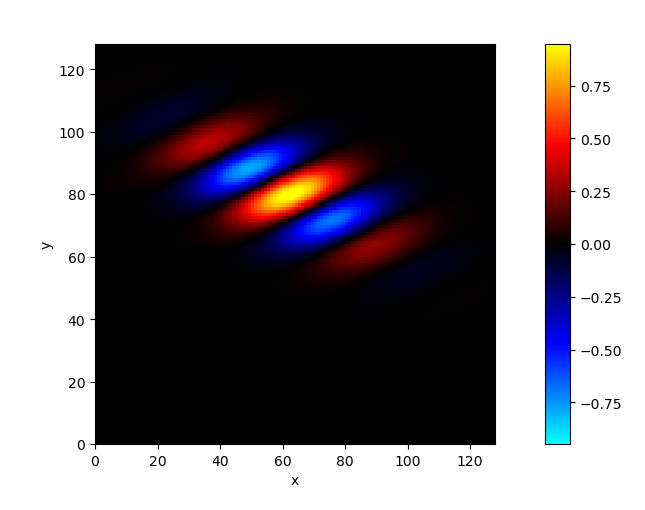

interactive(children=(SelectionSlider(description='sample', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (…

In [79]:
%autoreload

def wavelet(x, f, rotate, scale, shift, phase):
    Tx = x - shift
    Tx = np.einsum('...ij,...j', np.linalg.inv(rotate), Tx)
    Tx = np.einsum('...ij,...j', np.linalg.inv(scale), Tx)
    gaussian = np.exp(-4 * (Tx * Tx).sum(axis=-1))
    sine = np.sin(2 * np.pi * ((f * x).sum(axis=-1) + phase))
    return gaussian * sine

n_samples = 32
n_nodes  = 128
n_freqs  =  32

# define spatial and frequency domain
x = np.linspace(0, 1, n_nodes)
x = np.stack(np.meshgrid(x, x, indexing='ij'), axis=-1)

f = np.arange(-n_freqs // 2, n_freqs - n_freqs // 2)
f = np.stack(np.meshgrid(f, f, indexing='ij'), axis=-1)

# construct wavelet basis for each sample

scale_mat = np.zeros((n_samples, 1, 1, 1, 1, 2, 2))
scale = np.random.uniform(0.2, 1, (n_samples, 1, 1, 1, 1, 2))
scale_mat[...,0,0] = scale[...,0]
scale_mat[...,1,1] = scale[...,1]

angle_mat = np.zeros((n_samples, 1, 1, 1, 1, 2, 2))
angle = np.random.uniform(0, np.pi, (n_samples, 1, 1, 1, 1))
angle_mat[...,0,0] =  np.cos(angle)
angle_mat[...,0,1] = -np.sin(angle)
angle_mat[...,1,0] =  np.sin(angle)
angle_mat[...,1,1] =  np.cos(angle)

shift = np.random.uniform(0.3, 0.7, (n_samples, 1, 1, 1, 1, 2))
phase = np.random.uniform(0, 1, (n_samples, n_freqs, n_freqs, 1, 1))

basis = wavelet(x[None,None,None,:,:], f[None,:,:,None,None], angle_mat, scale_mat, shift, phase)

basis_xr = xr.DataArray(
    basis,
    dims=['sample', 'freq_x', 'freq_y', 'x', 'y'],
    name='wave'
)
code.visual.XArrayViewer(basis_xr, x='x', y='y')

In [80]:
# randomly sample basis coefficients A[f,g] ~ N(0,r^||f,g||)
coefs = np.random.normal(0, 1, (n_samples, n_freqs, n_freqs))

# r controls exponential decay of higher frequencies
#   lower r -> smoother function
r = 0.7
coefs *= (r**np.linalg.norm(f[None,:,:,:], axis=-1))

# amplitude of resulting function is a geometric series
#   that converges to r / (1 - r) (I think?)
# normalize by this to control the output scale
coefs /= r / (1 - r)

<IPython.core.display.Javascript object>


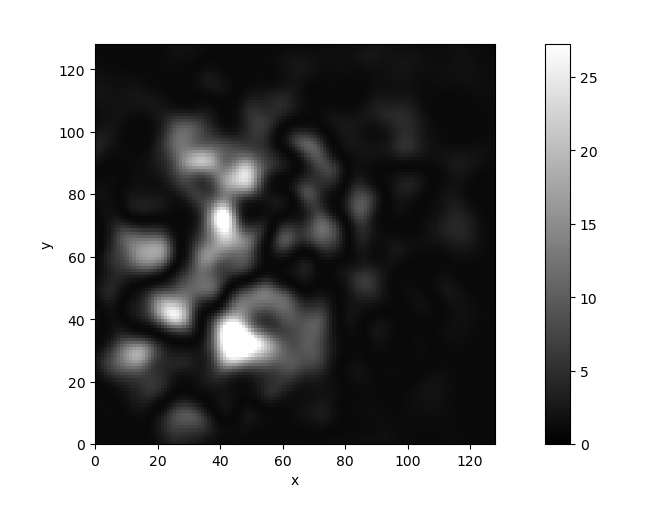

interactive(children=(SelectionSlider(description='sample', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (…

In [81]:
# mu is a nonlinear function of basis functions
a = np.einsum('ifg,ifgxy->ifgxy', coefs, basis)
mu_min, mu_max = (1, 10)
mu = (mu_max - mu_min) * a.sum(axis=(1,2))**2 + mu_min

mu_xr = xr.DataArray(
    mu,
    dims=['sample', 'x', 'y'],
    name='anat'
)
code.visual.XArrayViewer(mu_xr, x='x', y='y')

# 2) Solve PDE to generate ground truth

In [ ]:
# functions for converting between image-like arrays 
#   and vectors of dofs for a finite element basis

def image_to_dofs(image, V):
    '''
    Args:
        image: (batch_size, image_size) torch.Tensor
        V: (mesh_size, 1) fenics.FunctionSpace
    Returns:
        dofs: (batch_size, mesh_size) torch.Tensor
    '''
    batch_size, image_size = image.shape

    coords = V.tabulate_dof_coordinates()
    coords = np.c_[coords, coords*0]
    coords = torch.as_tensor(coords, dtype=image.dtype, device=image.device)
    
    mesh_size, n_dims = coords.shape
    coords = coords[None,None,:,:]

    return F.grid_sample(
        input=image.view(batch_size,1,1,image_size),
        grid=coords.expand(batch_size,1,mesh_size,n_dims) * 2 - 1,
        align_corners=True
    ).view(batch_size, mesh_size)

def dofs_to_image(dofs, V, image_size):
    '''
    Args:
        dofs: (batch_size, mesh_size) torch.Tensor
        V: (mesh_size,1) fenics.FunctionSpace
        image_size: int
    Returns:
        image: (batch_size, image_size) torch.Tensor
    '''
    batch_size, mesh_size = dofs.shape
    
    coords = np.linspace(0, 1, image_size)

    image = np.zeros((batch_size, image_size))
    for i in range(batch_size):
        func = torch_fenics.numpy_fenics.numpy_to_fenics(
            dofs[i].detach().cpu().numpy(), fe.Function(V)
        )
        for j in range(image_size):
            func.eval(image[i,j,None], x[j,None])

    return torch.as_tensor(image, device=dofs.device)

In [ ]:
class PDESolver(torch_fenics.FEniCSModule):
    
    def __init__(self, n_nodes):
        from fenics import grad, dot, dx, ds
        super().__init__()
        
        # create function space
        n_elements = n_nodes - 1
        mesh = fe.UnitIntervalMesh(n_elements)
        self.V = fe.FunctionSpace(mesh, 'P', 1)
        
        # create trial and test functions
        u = fe.TrialFunction(self.V)
        self.v = fe.TestFunction(self.V)
        
        # construct bilinear form
        self.a = inner(grad(u), grad(self.v)) *dx

    def solve(self, f, ub):
        from fenics import grad, dot, dx, ds
        
        # construct linear form
        L = f * self.v * dx
        
        # construct boundary condition
        bc = fa.DirichletBC(self.V, ub, 'on_boundary')
        
        # solve the Poisson equation
        u = fa.Function(self.V)
        fa.solve(self.a == L, u, bc)
        
        return u
    
    def input_templates(self):
        return fa.Function(self.V), fa.Constant(0)

In [ ]:
%%time

x  = torch.tensor(x,  dtype=torch.float64)
a  = torch.tensor(a,  dtype=torch.float64)
mu = torch.tensor(mu, dtype=torch.float64, requires_grad=True)
ub = torch.zeros(n_samples, 1, dtype=torch.float64, requires_grad=True)

for t in (x, a, mu, ub):
    print(t.shape, t.dtype, t.device)

print('solving forward problem')

pde_solver = PDESolver(n_nodes=128)
mu_dofs = image_to_dofs(mu, pde_solver.V)
u_dofs  = pde_solver.forward(mu_dofs, ub)
u = dofs_to_image(u_dofs, pde_solver.V, len(x))

for t in (mu_dofs, u_dofs, u):
    print(t.shape, t.dtype, t.device)

In [ ]:
%%time
print('solving adjoint problem')
L = (u_dofs.abs()**2).sum()
L.backward()
dL_dmu = mu.grad
dL_dub = ub.grad
dL_dmu.shape, dL_dub.shape

In [ ]:
plot1d(
    x,
    mu.detach().cpu().numpy(),
    u.detach().cpu().numpy(),
    dL_dmu.detach().cpu().numpy()
)
(dL_dmu == 0).sum()

# 3) Train neural network with PDE solver

In [ ]:
class PDEDataset(torch.utils.data.Dataset):

    def __init__(self, a, mu, u, ub, device):
        super().__init__()
        self.a  = a
        self.mu = mu
        self.u  = u
        self.ub = ub
        self.device = device
        
    @classmethod
    def generate(cls, n_samples, n_nodes, n_freqs, r=0.7, mu_lim=(1, 10), device='cuda'):

        # define spatial and frequency domain
        x = np.linspace(0, 1, n_nodes)
        f = np.arange(1, n_freqs + 1)
        
        # construct wavelet basis for each sample
        shift = np.random.uniform(0.2, 0.8, (n_samples, 1, 1))
        width = np.random.uniform(0.1, 0.6, (n_samples, 1, 1))
        phase = np.random.uniform(0, 1, (n_samples, n_freqs, 1))
        basis = wavelet(
            x[None,None,:] - shift, f[None,:,None], width, phase
        )
        
        # randomly sample basis coefficients and normalize
        coefs = np.random.normal(0, 1, (n_samples, n_freqs))
        coefs *= (r**f[None,:])
        coefs /= (r / (1 - r))
        
        # compute a features by weighting basis functions
        a = np.einsum('if,ifx->ifx', coefs, basis)

        # compute mu as nonlinear combination of basis functions
        mu = (mu_lim[1] - mu_lim[0]) * a.sum(axis=1)**2 + mu_lim[0]
        
        # convert a, mu, and u boundary condition to tensors
        a  = torch.tensor(a, dtype=torch.float64)
        mu = torch.tensor(mu, dtype=torch.float64)
        ub = torch.zeros(n_samples, 1, dtype=torch.float64)
        
        # solve forward PDE and convert result to image
        pde_solver = PDESolver(n_nodes)
        mu_dofs = image_to_dofs(mu, pde_solver.V)
        u_dofs  = pde_solver.forward(mu_dofs, ub)
        u = dofs_to_image(u_dofs, pde_solver.V, n_nodes)

        return cls(a, mu, u, ub, device)

    def __len__(self):
        return len(self.a)

    def __getitem__(self, idx):
        return (
            torch.as_tensor(self.a[idx]).to(self.device,  dtype=torch.float32),
            torch.as_tensor(self.mu[idx]).to(self.device, dtype=torch.float32),
            torch.as_tensor(self.u[idx]).to(self.device,  dtype=torch.float32),
            torch.as_tensor(self.ub[idx]).to(self.device, dtype=torch.float32)
        )
    
    def select(self,inds):
        a  = [self.a[i]  for i in inds]
        mu = [self.mu[i] for i in inds]
        u  = [self.u[i]  for i in inds]
        ub = [self.ub[i] for i in inds]
        return PDEDataset(a, mu, u, ub, self.device)
    
    def sample(self, n, seed=None):
        np.random.seed(seed)
        shuffled_inds = np.random.permutation(len(self))
        sampled_inds = shuffled_inds[:n]
        return self.select(sampled_inds)
    
    def split(self, n, seed=None):
        np.random.seed(seed)
        shuffled_inds = np.random.permutation(len(self))
        train_inds, test_inds = np.split(shuffled_inds, [n])
        train_data = self.select(train_inds)
        test_data = self.select(test_inds)
        return train_data, test_data 


dataset = PDEDataset.generate(n_samples=1000, n_nodes=128, n_freqs=32, device='cuda')
(a, mu, u, ub) = next(iter(torch.utils.data.DataLoader(dataset, batch_size=10)))
for t in (a, mu, u, ub):
    print(t.shape, t.dtype, t.device)

In [ ]:
class PDENet(torch.nn.Module):

    def __init__(self, n_nodes, n_inputs, n_filters, kernel_size, activ_fn):
        super().__init__()
        self.conv1 = torch.nn.Conv1d(n_inputs,  n_filters, kernel_size, padding=kernel_size//2, padding_mode='reflect')
        self.conv2 = torch.nn.Conv1d(n_filters, n_filters, kernel_size, padding=kernel_size//2, padding_mode='reflect')
        self.conv3 = torch.nn.Conv1d(n_filters, 1, kernel_size, padding=kernel_size//2, padding_mode='reflect')
        try:
            self.activ_fn = getattr(torch.nn.functional, activ_fn)
        except AttributeError:
            self.activ_fn = getattr(torch, activ_fn)
        self.pde_solver = PDESolver(n_nodes)

    def forward(self, a, ub):

        z1 = self.activ_fn(self.conv1(a))
        z2 = self.activ_fn(self.conv2(z1))
        mu = self.conv3(z2)[:,0,:]
        
        mu_dofs = image_to_dofs(mu, self.pde_solver.V)

        u_dofs = self.pde_solver.forward(
            mu_dofs.to('cpu', dtype=torch.float64),
            ub.to('cpu', dtype=torch.float64)
        ).cuda()

        return mu, u_dofs


model = PDENet(n_nodes=128, n_inputs=32, n_filters=16, kernel_size=5, activ_fn='leaky_relu').cuda()
mu_hat, u_dofs = model.forward(a, ub)
u_hat = dofs_to_image(u_dofs, model.pde_solver.V, len(x))

plot1d(
    x,
    a.detach().cpu().numpy()[0],
    mu.detach().cpu().numpy()[:1],
    mu_hat.detach().cpu().numpy()[:1],
    u.detach().cpu().numpy()[:1]
)

In [ ]:
class TrainingPlot(object):
    '''
    Interactive training plot.
    '''
    def __init__(self):
        
        # create subplots for loss and accuracy
        self.fig, ax = plt.subplots(1, 2, figsize=(8,4))
        ax[0].set_ylabel('u_loss')
        ax[1].set_ylabel('mu_loss')
        for ax_ in ax:
            ax_.set_axisbelow(True)
            ax_.grid(linestyle=':')
            ax_.set_xlabel('iteration')
        self.fig.tight_layout()
        
        # store data and artists for interactive ploting
        self.data = pd.DataFrame(columns=['iter', 'phase', 'u_loss', 'mu_loss'])

        self.train_u_loss_line = ax[0].plot([], [], label='train')[0]
        self.test_u_loss_line  = ax[0].plot([], [], label='test')[0]
        self.train_mu_loss_line = ax[1].plot([], [], label='train')[0]
        self.test_mu_loss_line  = ax[1].plot([], [], label='test')[0]
        
    def draw(self, pad=1e-8):
        ax = self.fig.get_axes()
        ax[0].set_xlim(0, self.data.iter.max() * 1.1 + pad)
        ax[0].set_ylim(0, self.data.u_loss.max() * 1.1 + pad)
        ax[1].set_xlim(0, self.data.iter.max() * 1.1 + pad)
        ax[1].set_ylim(0, self.data.mu_loss.max() * 1.1 + pad)
        self.fig.canvas.draw()
        
    def update_train(self, iteration, u_loss, mu_loss):
        self.data.loc[len(self.data)] = [iteration, 'train', u_loss.item(), mu_loss.item()]
        
        data = self.data.groupby(['phase', 'iter']).mean()
        train = data.loc['train'].reset_index()
        if isinstance(train, pd.Series): # need > 1 rows
            return
        
        self.train_u_loss_line.set_xdata(train.iter)
        self.train_u_loss_line.set_ydata(train.u_loss)

        self.train_mu_loss_line.set_xdata(train.iter)
        self.train_mu_loss_line.set_ydata(train.mu_loss)

        self.draw()
        
    def update_test(self, iteration, u_loss, mu_loss):
        self.data.loc[len(self.data)] = [iteration, 'test', u_loss.item(), mu_loss.item()]
        
        data = self.data.groupby(['phase', 'iter']).mean()
        test = data.loc['test'].reset_index()
        if isinstance(test, pd.Series): # need > 1 rows
            return
        
        self.test_u_loss_line.set_xdata(test.iter)
        self.test_u_loss_line.set_ydata(test.u_loss) 
        
        self.test_mu_loss_line.set_xdata(test.iter)
        self.test_mu_loss_line.set_ydata(test.mu_loss)
        
        self.draw()

In [ ]:
def train(dataset, model, optim, batch_size, n_epochs, verbose=False):

    # split dataset and create data loaders
    train_set, test_set = dataset.split(n=int(0.9 * len(dataset)), seed=0)
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=batch_size, shuffle=True
    )
    
    # set model to training mode
    model.train()
    
    # loss function
    loss_fn = F.mse_loss
    
    # setup training plot
    plot = TrainingPlot()
   
    if verbose:
        epoch_iterator = range(n_epochs)
    else:
        epoch_iterator = tqdm.tqdm(range(n_epochs), file=sys.stdout)
    
    # start training loop
    iteration = 0
    for epoch in epoch_iterator:

        # train phase
        if verbose:
            print(f'Epoch {epoch+1}/{n_epochs}')
            print('Training...')
            train_iterator = tqdm.tqdm(train_loader, file=sys.stdout)
        else:
            train_iterator = train_loader
    
        model.train()
        for i, (a, mu, u, ub) in enumerate(train_iterator):
            mu_hat, u_hat_dofs = model.forward(a, ub)
            u_dofs = image_to_dofs(u, model.pde_solver.V).to(torch.float64)
            u_loss = loss_fn(u_hat_dofs, u_dofs)
            mu_loss = loss_fn(mu_hat, mu)
            plot.update_train(iteration, u_loss, mu_loss)
            u_loss.backward()
            optim.step()
            iteration += 1
        
        # val phase
        if verbose:
            print('Evaluating...')
            test_iterator = tqdm.tqdm(test_loader, file=sys.stdout)
        else:
            test_iterator = test_loader
    
        model.eval()
        for i, (a, mu, u, ub) in enumerate(test_iterator):
            with torch.no_grad():
                mu_hat, u_hat_dofs = model.forward(a, ub)
                u_dofs = image_to_dofs(u, model.pde_solver.V).to(torch.float64)
                u_loss = loss_fn(u_hat_dofs, u_dofs)
                mu_loss = loss_fn(mu_hat, mu)
                plot.update_test(iteration, u_loss, mu_loss)


In [ ]:
%%time
optim = torch.optim.Adam(model.parameters(), lr=1e-5)
train(dataset, model, optim, batch_size=100, n_epochs=200)

In [ ]:
test_set = PDEDataset.generate(n_samples=100, n_freqs=32, n_nodes=128, device='cuda')

In [ ]:
a, mu, u, ub = next(iter(torch.utils.data.DataLoader(test_set, batch_size=3, shuffle=True)))
mu_hat, u_hat = model.forward(a, ub)

plot1d(
    x,
    a.detach().cpu().numpy()[0],
    mu.detach().cpu().numpy(),
    mu_hat.detach().cpu().numpy(),
    u.detach().cpu().numpy(),
    u_hat.detach().cpu().numpy(),
)

## Adjoint method derivation

A PDE constraint implicitly defines $\mathbf{u}(\mu)$:
$$
\begin{align*}
    \mathbf{r}(\mathbf{u};\mu) = 0
\end{align*}
$$

Loss function
$$
\begin{align*}
    L(\mathbf{u},\mu)
\end{align*}
$$

Loss gradient
$$
\begin{align*}
    dL &= \frac{\partial L}{\partial \mu} d\mu + \frac{\partial L}{\partial \mathbf{u}} d \mathbf{u} \\
    \frac{dL}{d\mu} &= \frac{\partial L}{\partial \mu} + \frac{\partial L}{\partial \mathbf{u}} \frac{d\mathbf{u}}{d\mu}
\end{align*}
$$

Assume that $\mathbf{r} = 0$
$$
\begin{align*}
    d\mathbf{r} &= 0 \\ 
    \frac{\partial \bf r}{\partial \bf u} d\mathbf{u} + \frac{\partial \bf r}{\partial \mu} d\mu &= 0 \\
    \frac{\partial \bf r}{\partial \bf u} \frac{d \bf u}{d \mu} + \frac{\partial \bf r}{\partial \mu} &= 0 \\
    \frac{\partial \bf r}{\partial \bf u} \frac{d \bf u}{d \mu} &= -\frac{\partial \bf r}{\partial \mu} \\
    \frac{d \bf u}{d \mu} &= -\frac{\partial \bf r}{\partial \bf u}^{-1} \frac{\partial \bf r}{\partial \mu}
\end{align*}
$$

This result is part of the implicit function theorem.

Then:
$$
\begin{align*}
    \frac{dL}{d\mu} &= \frac{\partial L}{\partial \mu} + \frac{\partial L}{\partial \bf u} \frac{d \bf u}{d \mu} \\
    \frac{dL}{d\mu} &= \frac{\partial L}{\partial \mu} - \frac{\partial L}{\partial \bf u} \left( \frac{\partial \bf r}{\partial \bf u} ^{-1} \frac{\partial \bf r}{\partial \mu} \right) \\
    \frac{dL}{d\mu} &= \frac{\partial L}{\partial \mu} - \left( \frac{\partial L}{\partial \bf u} \frac{\partial \bf r}{\partial \bf u} ^{-1} \right) \frac{\partial \bf r}{\partial \mu} \\
\end{align*}
$$

Direct method:

$$
\begin{align*}
    \Phi &= \frac{\partial \bf r}{\partial \bf u} ^{-1} \frac{\partial \bf r}{\partial \mu} \\
    \frac{dL}{d\mu} &= \frac{\partial L}{\partial \mu} - \frac{\partial L}{\partial \bf u} \Phi \\
    \operatorname{solve} \, \frac{\partial \bf r}{\partial \bf u} \Phi &= \frac{\partial \bf r}{\partial \mu}
\end{align*}
$$

Adjoint method:

$$
\begin{align*}
    \Psi^\top &= \frac{\partial L}{\partial \bf u} \frac{\partial \bf r}{\partial \bf u} ^{-1} \\
    \frac{dL}{d\mu} &= \frac{\partial L}{\partial \mu} - \Psi^\top \frac{\partial \bf r}{\partial \mu} \\
    \operatorname{solve} \, \frac{\partial \bf r}{\partial \bf u}^\top \Psi &= \frac{\partial L}{\partial \bf u}^\top
\end{align*}
$$

In either case, the output is $\frac{d L}{d \mu}$.

In [ ]:
class ImplicitPDELayer(object):

    def forward(self, mu):
        u = solve_pde(mu)
        return u

    def backward(self, dL_du, dL_dmu, dr_du, dr_dmu, method='adjoint'):
    
        if method == 'direct':
            phi = torch.linalg.solve(dr_du, dr_dmu)
            grad = dL_dmu - dL_du @ phi
    
        elif method == 'adjoint':
            psi = torch.linalg.solve(dr_du.T, dL_du.T)
            grad = dL_dmu - psi.T @ dr_dmu
            
        return grad
